##### Imports


In [19]:
import hashlib
import pathlib
from pathlib import Path

import pandas as pd
import numpy as np
from typing import List, Tuple, Dict

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import mlflow
import mlflow.sklearn

# point to local mlruns folder
root_mlruns = Path.cwd().parent / "mlruns"
mlflow.set_tracking_uri(f"file:{root_mlruns}")
mlflow.set_experiment("raop_modeling")


<Experiment: artifact_location=('file:c:\\Users\\mzouicha\\OneDrive - Amadeus '
 'Workplace\\Desktop\\STAGE\\raop-pizza\\mlruns/638776138218867233'), creation_time=1750366910368, experiment_id='638776138218867233', last_update_time=1750366910368, lifecycle_stage='active', name='raop_modeling', tags={}>

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent   
src_folder   = project_root / "src" 

sys.path.insert(0, str(src_folder))

from text_clustering import (
    load_and_clean,
    embed_texts,
    reduce_dimensionality,
    cluster_points,
    compute_centroids,
    compute_distances,
    assign_features,
)

##### 1- config


In [ ]:
DATA_PATH = Path(r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\data\processed\dataset_clean.csv")
RANDOM_STATE = 42
N_SPLITS = 5

# features
NUMERIC_FEATURES = [
    "requester_account_age_in_days_at_request",
    "requester_number_of_posts_at_request",
    "requester_number_of_comments_at_request",
    "requester_upvotes_plus_downvotes_at_request",

]

CATEGORICAL_FEATURES = [
    "post_was_edited",
]

TEXT_FEATURE = "request_text_edit_aware"
TARGET = "requester_received_pizza"

top_subs = [
    'reddit.com','fffffffuuuuuuuuuuuu','Random_Acts_Of_Pizza',
    'pics','AskReddit','IAmA','funny','todayilearned',
    'WTF','videos'
]

def list_leak_columns(df: pd.DataFrame) -> List[str]:
    retrieval_cols = [c for c in df.columns if c.endswith("_at_retrieval")]
    leaks = ["giver_username_if_known"] + retrieval_cols + ["requester_user_flair"]
    return leaks

def select_feature_sets(df: pd.DataFrame) -> Tuple[List[str], List[str], str]:
    text_col = "request_text_edit_aware"
    num = [
        # original at-request numerics
        "requester_account_age_in_days_at_request",
        "requester_number_of_posts_at_request",
        "requester_number_of_comments_at_request",
        "requester_upvotes_plus_downvotes_at_request",
        # time-based
        "hour_sin", "hour_cos", "dow_sin", "dow_cos", "log_account_age",
        # activity rates
        "posts_per_day", "comments_per_day", "votes_per_day", "subreddits_per_day",
        # text-derived
        "n_chars", "n_words", "cnt_please", "cnt_thank", "sentiment",
        # social-proof
        "vote_sum", "vote_diff", "vote_ratio",
        # interactions
        "hour_sentiment", "length_upvote",
        # subreddit-history
        *[f"sub_{s}" for s in top_subs],
        "num_top_subs"
    ]
    cat = [
        "post_was_edited",
    ]
    
    dist_cols = [c for c in df.columns if c.startswith("dist_")]
    num += dist_cols
    cat += ["cluster_id"]
    return num, cat, text_col


##### 2- Data loading / Split

In [ ]:
def load_clean_data(path: Path, target: str) -> Tuple[pd.DataFrame, pd.Series]:
    df = pd.read_csv(path, parse_dates=["request_time_utc"])
    df[target] = df[target].astype(int)

    leak_cols = list_leak_columns(df)
    df = df.drop(columns=leak_cols, errors="ignore")

    X = df.drop(columns=[target])
    y = df[target]
    return X, y

TEXT_COL = "request_text_edit_aware"

df_raw, texts = load_and_clean(
    csv_path=str(DATA_PATH),
    text_column=TEXT_COL,
)

##### 3- Preprocessing pipelines 

In [ ]:
from sklearn.impute import SimpleImputer

def build_preprocessor(df, 
                       candidate_num, 
                       candidate_cat, 
                       candidate_text, 
                       tfidf_max=5_000, 
                       svd_components=100, 
                       random_state=42):
    #Filter to only columns that actually exist
    num_cols = [c for c in candidate_num if c in df.columns]
    cat_cols = [c for c in candidate_cat if c in df.columns]
    text_col = candidate_text if candidate_text in df.columns else None

    transformers = []

    # Numeric pipeline
    if num_cols:
        num_pipe = Pipeline([
            ("select_num", FunctionTransformer(lambda D: D[num_cols], validate=False)),
            ("to_float",   FunctionTransformer(lambda D: D.astype(float), validate=False)),
            ("impute",     SimpleImputer(strategy="median")),
            ("scale",      StandardScaler()),
        ])
        transformers.append(("num", num_pipe))

    #Categorical pipeline
    if cat_cols:
        cat_pipe = Pipeline([
            ("select_cat", FunctionTransformer(lambda D: D[cat_cols], validate=False)),
            ("to_str",     FunctionTransformer(lambda D: D.astype(str), validate=False)),
            ("impute",     SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot",     OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        transformers.append(("cat", cat_pipe))

    #Text pipeline
    if text_col:
        txt_pipe = Pipeline([
            ("select_txt", FunctionTransformer(lambda D: D[text_col].fillna("").astype(str), validate=False)),
            ("tfidf",      TfidfVectorizer(max_features=tfidf_max, ngram_range=(1,2))),
            ("svd",        TruncatedSVD(n_components=svd_components, random_state=random_state)),
        ])
        transformers.append(("txt", txt_pipe))

    if not transformers:
        raise ValueError("No features found to build a preprocessor.")
    return FeatureUnion(transformers)

##### 4 - Model Pipeline & Hyperparameter Grid

In [ ]:
def run_experiment(
    X: pd.DataFrame,
    y: pd.Series,
    exp_name: str,
    run_name: str,
    model_cls,
    param_grid: Dict,
    n_splits: int = 5,
    random_state: int = 42,
) -> Tuple[Pipeline, str, float]:

    mlflow.set_experiment(exp_name)

    # build preprocessing for current X
    num, cat, text = select_feature_sets(X)
    pre = build_preprocessor(X, num, cat, text)

    pipe = Pipeline([("pre", pre), ("clf", model_cls())])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        n_iter=15,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=random_state,
        verbose=0,
    )

    with mlflow.start_run(run_name=run_name) as run:
        run_id = run.info.run_id

        data_path_str = X.attrs.get("source_path", "unknown")
        if data_path_str != "unknown":
            md5 = hashlib.md5(open(data_path_str, "rb").read()).hexdigest()
            mlflow.log_param("dataset_md5", md5)

        mlflow.log_metric("prevalence", y.mean())

        search.fit(X, y)

        mlflow.log_params(search.best_params_)
        mlflow.log_metric("best_cv_roc_auc", search.best_score_)
        mlflow.sklearn.log_model(search.best_estimator_, "model")

    return search.best_estimator_, run_id, search.best_score_



#####  5- Cross-Validation & MLflow Tracking

In [ ]:
from sklearn.metrics import roc_auc_score
import warnings

def detect_single_feature_auc(X: pd.DataFrame, y: pd.Series, top_k: int = 20):
    suspicious = []
    for col in X.columns:
        series = X[col]

        # numeric or boolean
        if pd.api.types.is_numeric_dtype(series) or pd.api.types.is_bool_dtype(series):
            values = series.fillna(0)
        else:
            # for categoricals 
            values = series.notna().astype(int)

        if values.nunique() < 2:
            continue

        try:
            auc = roc_auc_score(y, values)
            if auc > 0.90 or auc < 0.10:     
                suspicious.append((col, auc))
        except ValueError:
            continue

    suspicious_sorted = sorted(suspicious, key=lambda x: -abs(x[1] - 0.5))
    print(f"Top {min(top_k, len(suspicious_sorted))} suspicious columns:")
    for name, auc in suspicious_sorted[:top_k]:
        print(f"{name:<45}  AUC={auc:.3f}")


DATA_PATH = Path(r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\data\processed\dataset_clean.csv")
TARGET = "requester_received_pizza"

X, y = load_clean_data(DATA_PATH, TARGET)
X.attrs["source_path"] = str(DATA_PATH) 

detect_single_feature_auc(X, y)

Top 0 suspicious columns:


### 6 -  Feature Engineering


#### 6-1- Calendar features

###### 6.1.1 Time-based feature function

In [ ]:
def add_time_features(df):
    df = df.copy()
    df['hour'] = df['request_time_utc'].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow'] = df['request_time_utc'].dt.weekday
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['log_account_age'] = np.log1p(df['requester_account_age_in_days_at_request'])
    return df

X_time = add_time_features(X)
print(X_time[['hour_sin','hour_cos','dow_sin','dow_cos','log_account_age']].describe())
detect_single_feature_auc(X_time, y)


          hour_sin      hour_cos      dow_sin      dow_cos  log_account_age
count  4040.000000  4.040000e+03  4040.000000  4040.000000      4040.000000
mean     -0.265913  4.190971e-01     0.037769     0.016861         4.035968
std       0.630506  5.969055e-01     0.712552     0.700576         2.490760
min      -1.000000 -1.000000e+00    -0.974928    -0.900969         0.000000
25%      -0.866025 -1.836970e-16    -0.781831    -0.900969         1.498004
50%      -0.500000  7.071068e-01     0.000000    -0.222521         5.063020
75%       0.258819  8.660254e-01     0.781831     0.623490         5.968944
max       1.000000  1.000000e+00     0.974928     1.000000         7.941207
Top 0 suspicious columns:


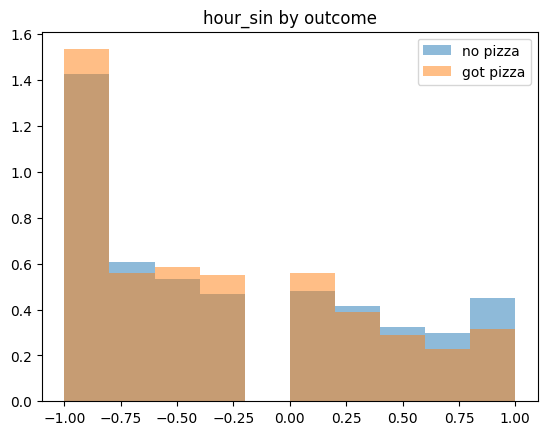

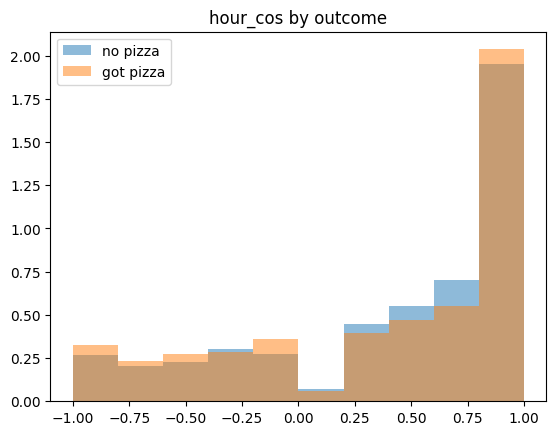

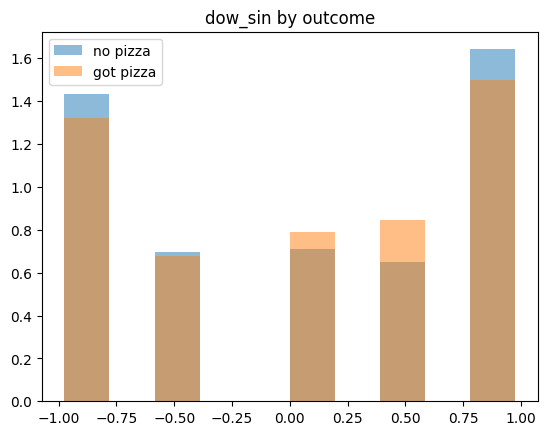

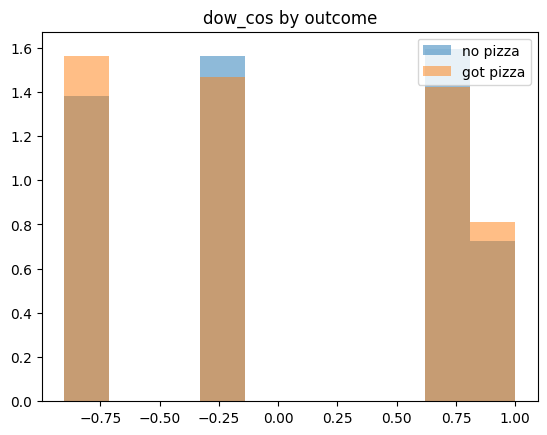

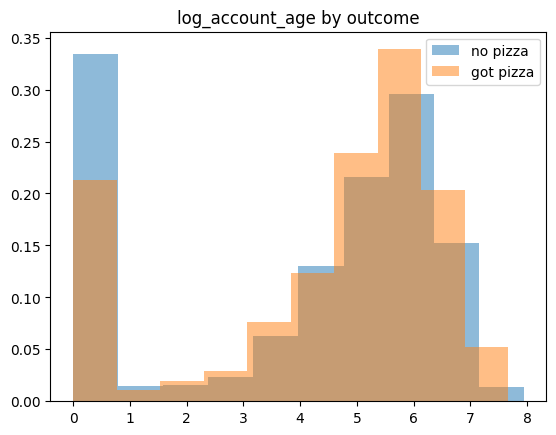

Time Features Leaderboard:
        feature    t_stat      p_value      auc
log_account_age  5.662813 1.592677e-08 0.543914
       hour_sin -2.698486 6.994543e-03 0.476484
       hour_cos -1.502255 1.331095e-01 0.494362
        dow_cos -1.223578 2.211828e-01 0.491474
        dow_sin  0.518564 6.040932e-01 0.504000


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

df_time = X_time.copy()
df_time['target'] = y.values

# Plot distributions
for col in ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'log_account_age']:
    plt.figure()
    plt.hist(df_time.loc[df_time['target']==0, col], alpha=0.5, density=True, label='no pizza')
    plt.hist(df_time.loc[df_time['target']==1, col], alpha=0.5, density=True, label='got pizza')
    plt.title(f'{col} by outcome')
    plt.legend()
    plt.show()

# Build leaderboard
results = []
for col in ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'log_account_age']:
    g1 = df_time[df_time['target']==1][col].dropna()
    g0 = df_time[df_time['target']==0][col].dropna()
    stat, p = ttest_ind(g1, g0, nan_policy='omit')
    auc = roc_auc_score(df_time['target'], df_time[col].fillna(0))
    results.append((col, stat, p, auc))

leader_time = pd.DataFrame(results, columns=['feature','t_stat','p_value','auc']) \
                .sort_values('p_value')
print("Time Features Leaderboard:")
print(leader_time.to_string(index=False))


###### 6.1.2 Activity-rate feature function

In [ ]:
#Activity-rate feature function
def add_activity_features(df):
    df = df.copy()
    df['posts_per_day'] = df['requester_number_of_posts_at_request'] / df['requester_account_age_in_days_at_request'].replace(0, np.nan)
    df['comments_per_day'] = df['requester_number_of_comments_at_request'] / df['requester_account_age_in_days_at_request'].replace(0, np.nan)
    df['votes_per_day'] = df['requester_upvotes_plus_downvotes_at_request'] / df['requester_account_age_in_days_at_request'].replace(0, np.nan)
    df['subreddits_per_day'] = df['requester_number_of_subreddits_at_request'] / df['requester_account_age_in_days_at_request'].replace(0, np.nan)
    return df

X_act = add_activity_features(X)
print(X_act[['posts_per_day','comments_per_day','votes_per_day','subreddits_per_day']].describe())
detect_single_feature_auc(X_act, y)


       posts_per_day  comments_per_day  votes_per_day  subreddits_per_day
count    3139.000000       3139.000000    3139.000000         3139.000000
mean        0.418156          1.034282      22.376743            0.702056
std         8.318533          6.474052     113.467755            9.887780
min         0.000000          0.000000       0.000000            0.000818
25%         0.014049          0.078546       1.157978            0.040487
50%         0.048082          0.303460       4.324666            0.077752
75%         0.130277          0.808478      13.646727            0.148784
max       438.578680        220.408163    2858.668470          438.578680
Top 0 suspicious columns:


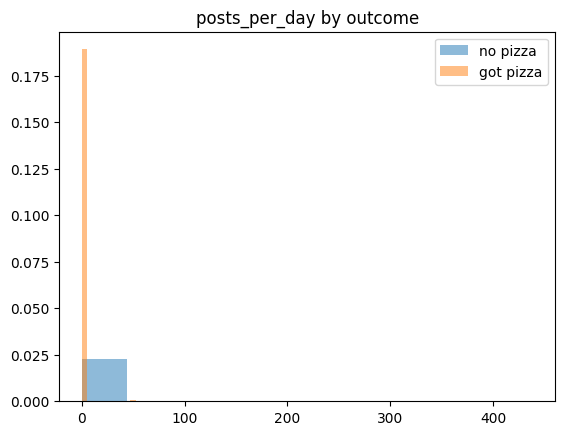

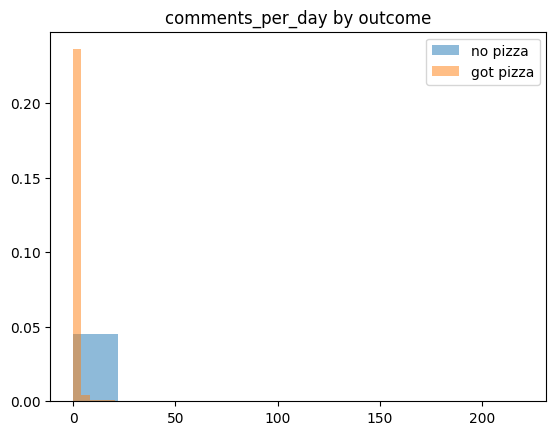

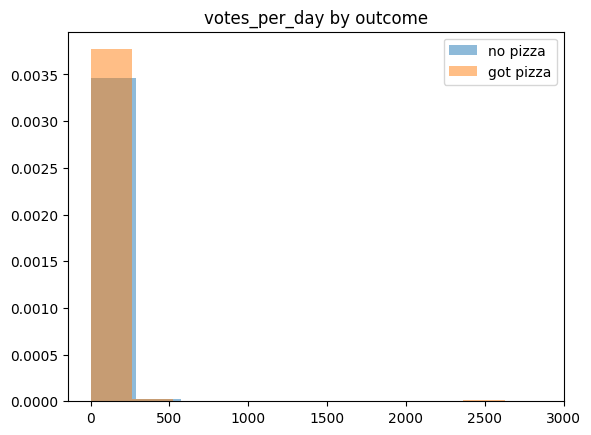

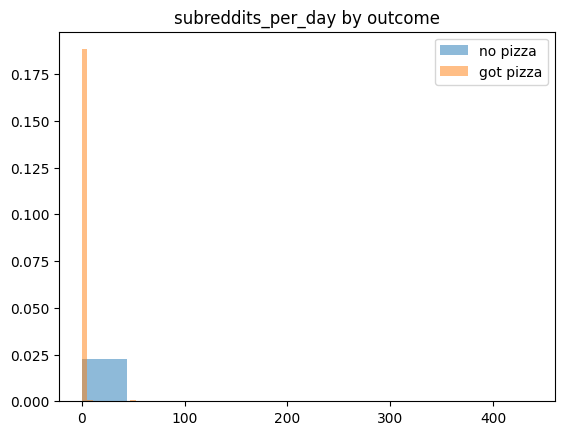

Activity-Rate Features Leaderboard:
           feature    t_stat  p_value      auc
  comments_per_day -1.127082 0.259794 0.550460
subreddits_per_day -1.004033 0.315440 0.561866
     votes_per_day  0.602396 0.546954 0.569523
     posts_per_day -0.506198 0.612753 0.540806


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

df_act = X_act.copy()
df_act['target'] = y.values

for col in ['posts_per_day', 'comments_per_day', 'votes_per_day', 'subreddits_per_day']:
    plt.figure()
    plt.hist(df_act.loc[df_act['target']==0, col], alpha=0.5, density=True, label='no pizza')
    plt.hist(df_act.loc[df_act['target']==1, col], alpha=0.5, density=True, label='got pizza')
    plt.title(f'{col} by outcome')
    plt.legend()
    plt.show()

results = []
for col in ['posts_per_day', 'comments_per_day', 'votes_per_day', 'subreddits_per_day']:
    g1 = df_act[df_act['target']==1][col].dropna()
    g0 = df_act[df_act['target']==0][col].dropna()
    stat, p = ttest_ind(g1, g0, nan_policy='omit')
    auc = roc_auc_score(df_act['target'], df_act[col].fillna(0))
    results.append((col, stat, p, auc))

leader_act = pd.DataFrame(results, columns=['feature','t_stat','p_value','auc']) \
                .sort_values('p_value')
print("Activity-Rate Features Leaderboard:")
print(leader_act.to_string(index=False))


###### 6.1.3 Text-derived feature function

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#Text-derived feature function
def add_text_features(df):
    df = df.copy()
    text = df['request_text_edit_aware'].fillna("").astype(str)
    df['n_chars'] = text.str.len()
    df['n_words'] = text.str.split().str.len()
    df['cnt_please'] = text.str.lower().str.count(r'\bplease\b')
    df['cnt_thank'] = text.str.lower().str.count(r'\bthank\b')
    df['sentiment'] = text.apply(lambda t: analyzer.polarity_scores(t)['compound'])
    return df

X_text = add_text_features(X)
print(X_text[['n_chars','n_words','cnt_please','cnt_thank','sentiment']].describe())
detect_single_feature_auc(X_text, y)


           n_chars      n_words   cnt_please    cnt_thank    sentiment
count  4040.000000  4040.000000  4040.000000  4040.000000  4040.000000
mean    390.798515    76.097030     0.100495     0.108663     0.514723
std     357.540986    69.475223     0.330507     0.327534     0.513107
min       0.000000     0.000000     0.000000     0.000000    -0.992400
25%     177.000000    34.000000     0.000000     0.000000     0.250000
50%     297.000000    58.000000     0.000000     0.000000     0.734500
75%     494.000000    96.000000     0.000000     0.000000     0.913200
max    4358.000000   854.000000     4.000000     3.000000     0.998000
Top 0 suspicious columns:


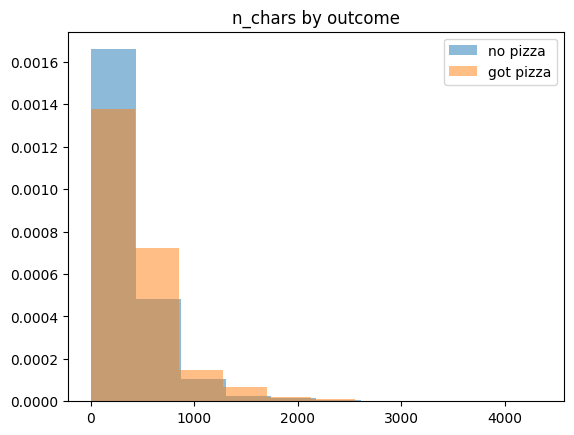

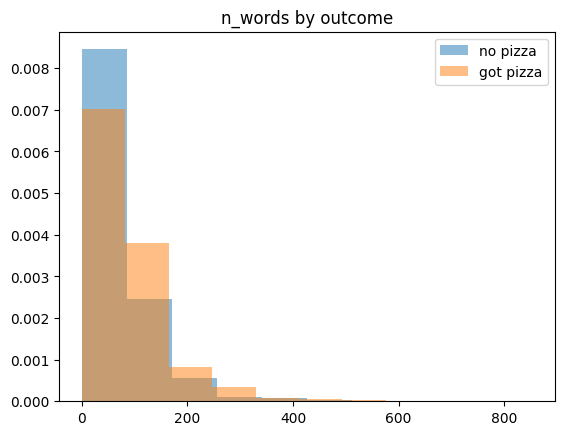

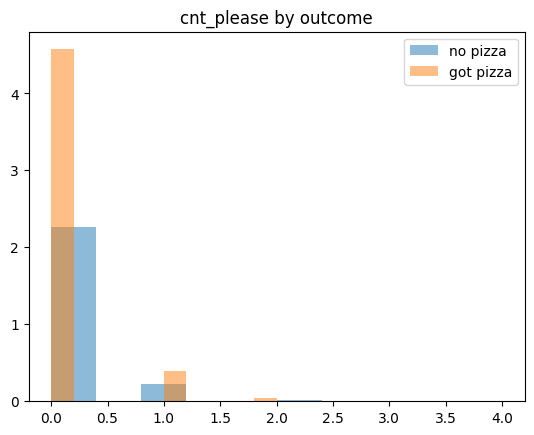

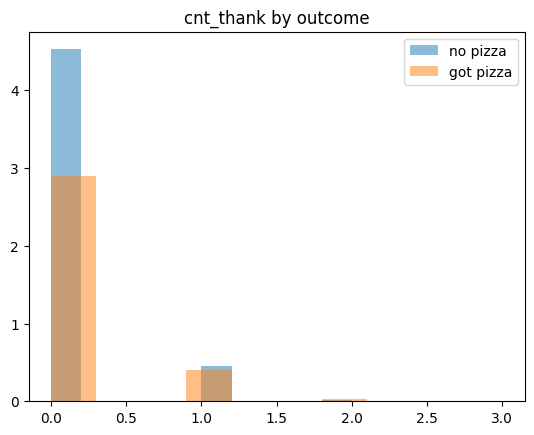

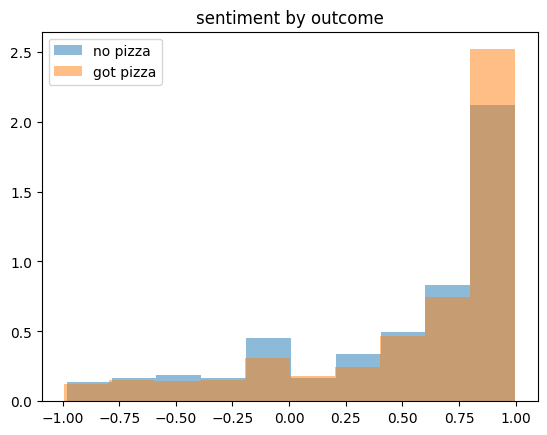

Text-Derived Features Leaderboard:
   feature    t_stat      p_value      auc
   n_chars  7.344185 2.491126e-13 0.594578
   n_words  7.246597 5.094478e-13 0.593778
 cnt_thank  3.796910 1.486627e-04 0.518903
 sentiment  3.474553 5.170859e-04 0.548524
cnt_please -0.761693 4.462878e-01 0.495563


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

df_text = X_text.copy()
df_text['target'] = y.values

for col in ['n_chars', 'n_words', 'cnt_please', 'cnt_thank', 'sentiment']:
    plt.figure()
    plt.hist(df_text.loc[df_text['target']==0, col], alpha=0.5, density=True, label='no pizza')
    plt.hist(df_text.loc[df_text['target']==1, col], alpha=0.5, density=True, label='got pizza')
    plt.title(f'{col} by outcome')
    plt.legend()
    plt.show()

results = []
for col in ['n_chars', 'n_words', 'cnt_please', 'cnt_thank', 'sentiment']:
    g1 = df_text[df_text['target']==1][col].dropna()
    g0 = df_text[df_text['target']==0][col].dropna()
    stat, p = ttest_ind(g1, g0, nan_policy='omit')
    auc = roc_auc_score(df_text['target'], df_text[col].fillna(0))
    results.append((col, stat, p, auc))

leader_text = pd.DataFrame(results, columns=['feature','t_stat','p_value','auc']) \
                 .sort_values('p_value')
print("Text-Derived Features Leaderboard:")
print(leader_text.to_string(index=False))


###### 6.1.3 Text-derived feature function

In [ ]:
#Social-proof feature function
def add_social_features(df):
    df = df.copy()
    df['vote_sum'] = df['requester_upvotes_plus_downvotes_at_request']
    df['vote_diff'] = df['requester_upvotes_minus_downvotes_at_request']
    df['vote_ratio'] = df['vote_diff'] / df['vote_sum'].replace(0, np.nan)
    return df

X_soc = add_social_features(X)
print(X_soc[['vote_sum','vote_diff','vote_ratio']].describe())
detect_single_feature_auc(X_soc, y)


           vote_sum      vote_diff   vote_ratio
count  4.040000e+03    4040.000000  3308.000000
mean   3.743236e+03    1160.079950     0.497549
std    2.583816e+04    3718.365515     0.222338
min    0.000000e+00    -173.000000    -1.000000
25%    9.000000e+00       3.000000     0.359835
50%    3.510000e+02     174.500000     0.525773
75%    2.303750e+03    1163.750000     0.636364
max    1.286864e+06  155010.000000     1.000000
Top 0 suspicious columns:


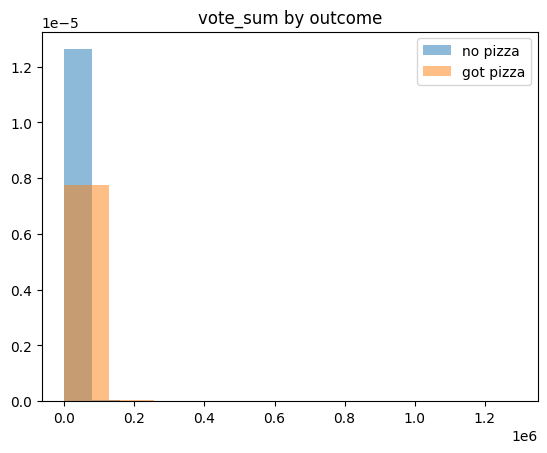

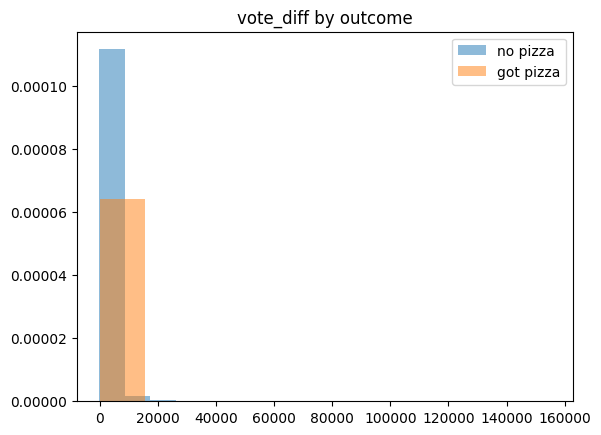

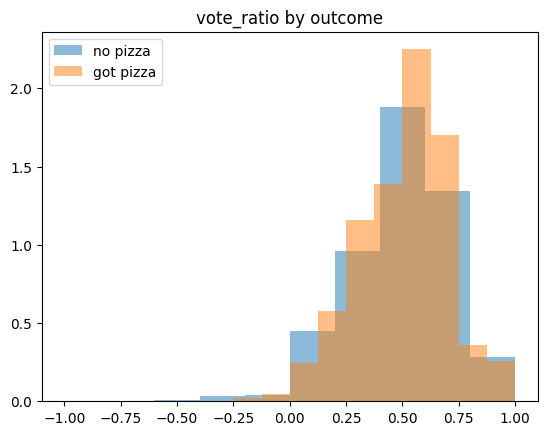

Social-Proof Features Leaderboard:
   feature   t_stat  p_value      auc
 vote_diff 2.070805 0.038440 0.563995
  vote_sum 1.659222 0.097149 0.562642
vote_ratio 1.248742 0.211848 0.550501


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

df_soc = X_soc.copy()
df_soc['target'] = y.values

for col in ['vote_sum', 'vote_diff', 'vote_ratio']:
    plt.figure()
    plt.hist(df_soc.loc[df_soc['target']==0, col], alpha=0.5, density=True, label='no pizza')
    plt.hist(df_soc.loc[df_soc['target']==1, col], alpha=0.5, density=True, label='got pizza')
    plt.title(f'{col} by outcome')
    plt.legend()
    plt.show()

results = []
for col in ['vote_sum', 'vote_diff', 'vote_ratio']:
    g1 = df_soc[df_soc['target']==1][col].dropna()
    g0 = df_soc[df_soc['target']==0][col].dropna()
    stat, p = ttest_ind(g1, g0, nan_policy='omit')
    auc = roc_auc_score(df_soc['target'], df_soc[col].fillna(0))
    results.append((col, stat, p, auc))

leader_soc = pd.DataFrame(results, columns=['feature','t_stat','p_value','auc']) \
                .sort_values('p_value')
print("Social-Proof Features Leaderboard:")
print(leader_soc.to_string(index=False))


In [ ]:
#Interaction feature function
def add_interaction_features(df):
    df = df.copy()
    df['hour_sentiment'] = df['hour_sin'] * df['sentiment']
    df['length_upvote'] = df['n_words'] * df['vote_ratio']
    return df

X_prev = add_time_features(X)
X_prev = add_text_features(X_prev)
X_prev = add_social_features(X_prev)
X_int = add_interaction_features(X_prev)
print(X_int[['hour_sentiment','length_upvote']].describe())
detect_single_feature_auc(X_int, y)


       hour_sentiment  length_upvote
count     4040.000000    3308.000000
mean        -0.137954      36.951162
std          0.476483      41.261570
min         -0.997200     -87.666667
25%         -0.496250      12.720740
50%         -0.121715      26.197174
75%          0.193793      47.056471
max          0.992100     475.000000
Top 0 suspicious columns:


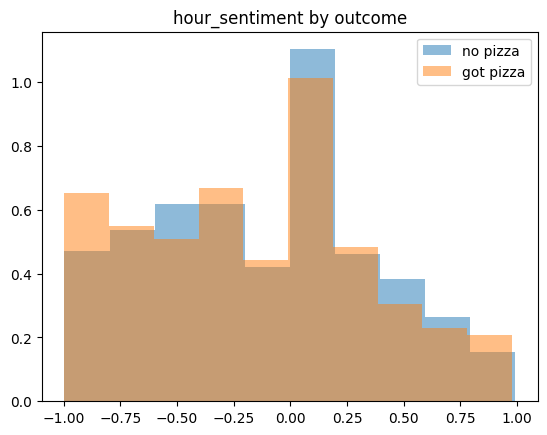

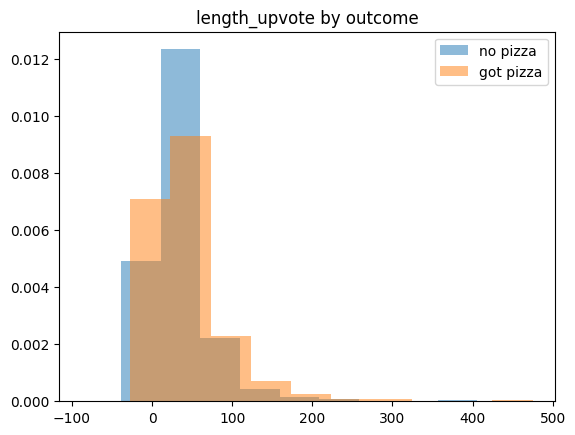

Interaction Features Leaderboard:
       feature    t_stat      p_value      auc
 length_upvote  7.274705 4.314999e-13 0.603959
hour_sentiment -1.771915 7.648399e-02 0.480152


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

df_int = X_int.copy()
df_int['target'] = y.values

for col in ['hour_sentiment', 'length_upvote']:
    plt.figure()
    plt.hist(df_int.loc[df_int['target']==0, col], alpha=0.5, density=True, label='no pizza')
    plt.hist(df_int.loc[df_int['target']==1, col], alpha=0.5, density=True, label='got pizza')
    plt.title(f'{col} by outcome')
    plt.legend()
    plt.show()

results = []
for col in ['hour_sentiment', 'length_upvote']:
    g1 = df_int[df_int['target']==1][col].dropna()
    g0 = df_int[df_int['target']==0][col].dropna()
    stat, p = ttest_ind(g1, g0, nan_policy='omit')
    auc = roc_auc_score(df_int['target'], df_int[col].fillna(0))
    results.append((col, stat, p, auc))

leader_int = pd.DataFrame(results, columns=['feature','t_stat','p_value','auc']) \
                .sort_values('p_value')
print("Interaction Features Leaderboard:")
print(leader_int.to_string(index=False))


In [ ]:

#Define top-K subreddits and feature function
top_subs = [
    'reddit.com','fffffffuuuuuuuuuuuu','Random_Acts_Of_Pizza',
    'pics','AskReddit','IAmA','funny','todayilearned',
    'WTF','videos'
]

def add_subreddit_features(df):
    df = df.copy()
    lists = df['requester_subreddits_at_request']
    for sub in top_subs:
        df[f'sub_{sub}'] = lists.apply(lambda L: 1 if sub in L else 0)
    df['num_top_subs'] = df[[f'sub_{s}' for s in top_subs]].sum(axis=1)
    return df

X_all = X.copy()
X_all = add_time_features(X_all)
X_all = add_activity_features(X_all)
X_all = add_text_features(X_all)
X_all = add_social_features(X_all)
X_all = add_interaction_features(X_all)
X_all = add_subreddit_features(X_all)

#X_all = X_all.fillna(0)
# drop low‐signal features
drop_cols = [
    'hour', 'dow', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
]
#X_all = X_all.drop(columns=drop_cols, errors='ignore')

X_all.attrs["source_path"] = str(DATA_PATH)
X_sub = add_subreddit_features(X_all)
print(X_sub[[f'sub_{s}' for s in top_subs] + ['num_top_subs']].describe().T)
detect_single_feature_auc(X_sub, y)




                           count      mean       std  min  25%  50%  75%   max
sub_reddit.com            4040.0  0.226238  0.418447  0.0  0.0  0.0  0.0   1.0
sub_fffffffuuuuuuuuuuuu   4040.0  0.216584  0.411968  0.0  0.0  0.0  0.0   1.0
sub_Random_Acts_Of_Pizza  4040.0  0.349752  0.476951  0.0  0.0  0.0  1.0   1.0
sub_pics                  4040.0  0.490347  0.499969  0.0  0.0  0.0  1.0   1.0
sub_AskReddit             4040.0  0.571040  0.494989  0.0  0.0  1.0  1.0   1.0
sub_IAmA                  4040.0  0.374505  0.484055  0.0  0.0  0.0  1.0   1.0
sub_funny                 4040.0  0.478713  0.499608  0.0  0.0  0.0  1.0   1.0
sub_todayilearned         4040.0  0.273020  0.445566  0.0  0.0  0.0  1.0   1.0
sub_WTF                   4040.0  0.375000  0.484183  0.0  0.0  0.0  1.0   1.0
sub_videos                4040.0  0.287376  0.452595  0.0  0.0  0.0  1.0   1.0
num_top_subs              4040.0  3.642574  3.048420  0.0  1.0  3.0  6.0  10.0
Top 0 suspicious columns:


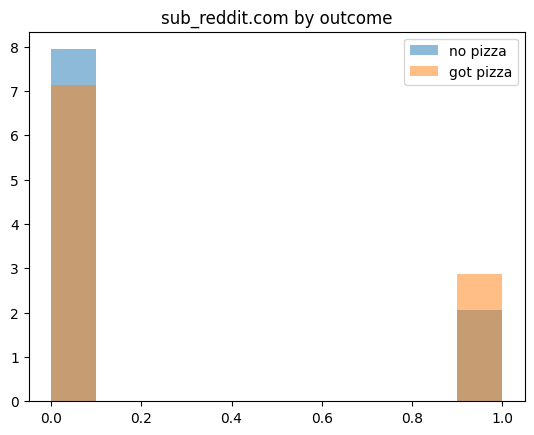

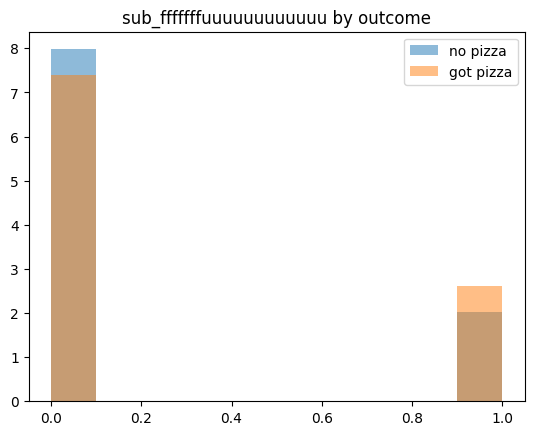

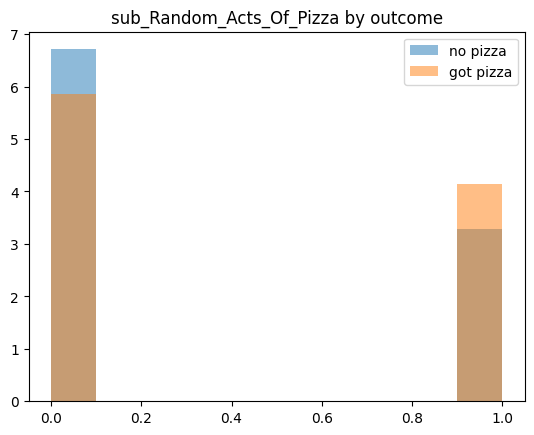

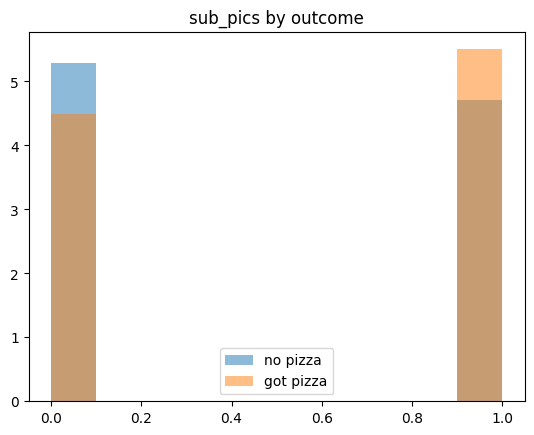

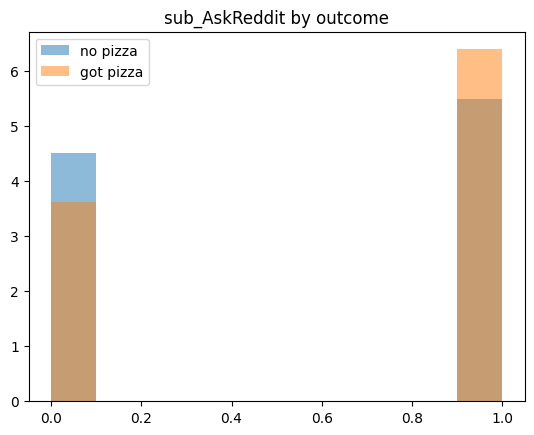

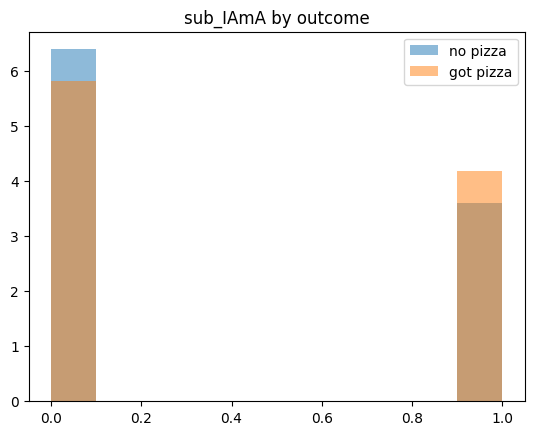

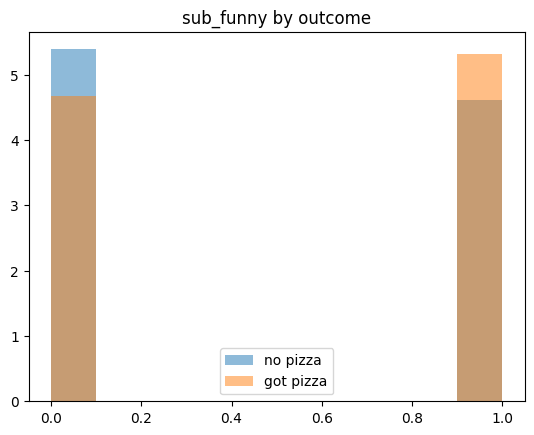

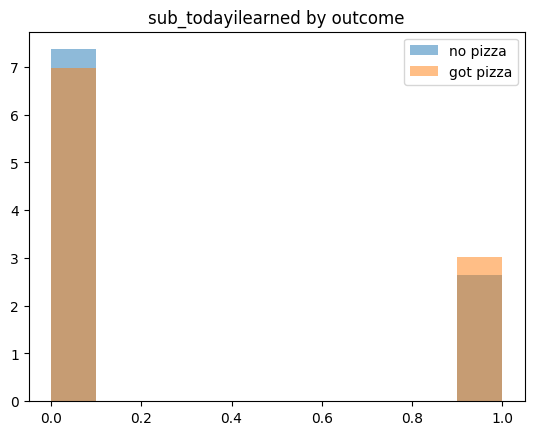

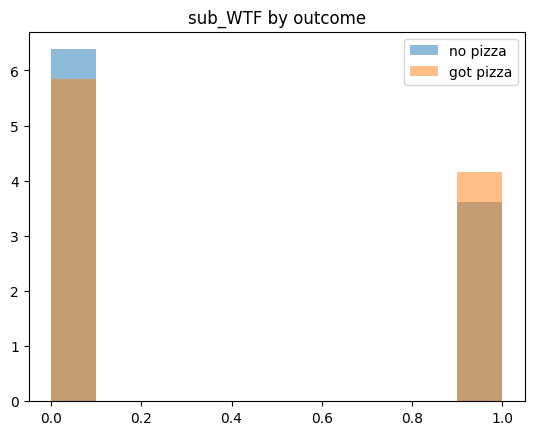

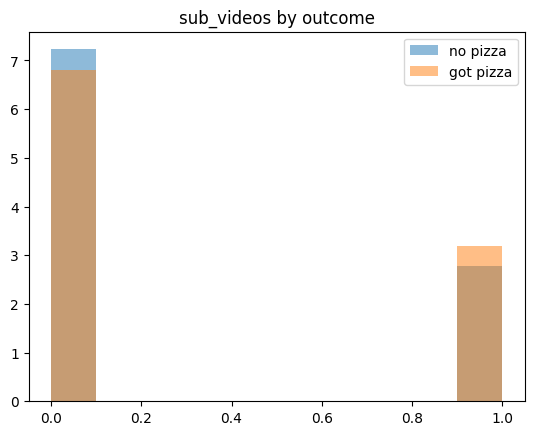

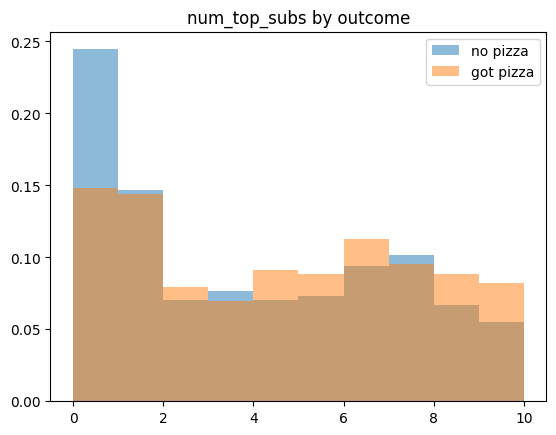

Subreddit Features Leaderboard:
                 feature   t_stat      p_value      auc
            num_top_subs 5.923742 3.409328e-09 0.564613
          sub_reddit.com 5.353732 9.094899e-08 0.540777
           sub_AskReddit 4.987589 6.370750e-07 0.544958
sub_Random_Acts_Of_Pizza 4.865123 1.187476e-06 0.542262
                sub_pics 4.363866 1.309781e-05 0.539760
               sub_funny 3.893523 1.003948e-04 0.535466
 sub_fffffffuuuuuuuuuuuu 3.882922 1.048587e-04 0.529165
                sub_IAmA 3.229238 1.251148e-03 0.528516
                 sub_WTF 3.039706 2.383270e-03 0.526854
              sub_videos 2.531768 1.138651e-02 0.520914
       sub_todayilearned 2.429653 1.515660e-02 0.519760


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

df_sub = X_sub.copy()
df_sub['target'] = y.values

# Plot distributions
for col in [*(f'sub_{s}' for s in top_subs), 'num_top_subs']:
    plt.figure()
    plt.hist(df_sub.loc[df_sub['target']==0, col], alpha=0.5, density=True, label='no pizza')
    plt.hist(df_sub.loc[df_sub['target']==1, col], alpha=0.5, density=True, label='got pizza')
    plt.title(f'{col} by outcome')
    plt.legend()
    plt.show()

# Build leaderboard
results = []
for col in [*(f'sub_{s}' for s in top_subs), 'num_top_subs']:
    g1 = df_sub[df_sub['target']==1][col].dropna()
    g0 = df_sub[df_sub['target']==0][col].dropna()
    stat, p = ttest_ind(g1, g0, nan_policy='omit')
    auc = roc_auc_score(df_sub['target'], df_sub[col].fillna(0))
    results.append((col, stat, p, auc))

leader_sub = pd.DataFrame(results, columns=['feature','t_stat','p_value','auc']) \
               .sort_values('p_value')
print("Subreddit Features Leaderboard:")
print(leader_sub.to_string(index=False))

all mini lm v2


In [38]:
import importlib
import text_clustering
importlib.reload(text_clustering)


<module 'text_clustering' from 'c:\\Users\\mzouicha\\OneDrive - Amadeus Workplace\\Desktop\\STAGE\\raop-pizza\\src\\text_clustering.py'>

In [ ]:
EMB_MODEL = r"C:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\all-MiniLM-L6-v2"
embs = embed_texts(texts, model_name=EMB_MODEL, batch_size=64)

# UMAP down to 10 components
X_umap, umap_reducer = reduce_dimensionality(
    embs,
    n_components=10,
    n_neighbors=15,
    min_dist=0.1,
)
# Cluster in embedding space
labels, hdb = cluster_points(
    X_umap,
    min_cluster_size=30,
    min_samples=5,
)
centroids = compute_centroids(X_umap, labels)
dmat = compute_distances(X_umap, centroids, scale=True)


def assign_features_1(
    df: pd.DataFrame,
    embs: np.ndarray,
    labels: np.ndarray,
    distances: np.ndarray,
    embed_col: str = "embedding"
) -> pd.DataFrame:
    out = df.copy()
    out["cluster_id"] = labels
    # store full embedding per row
    out[embed_col] = list(embs)
    all_clusters = sorted(c for c in set(labels) if c >= 0)
    n_cols = distances.shape[1]
    used_clusters = all_clusters[:n_cols]
    for idx, cid in enumerate(used_clusters):
        out[f"dist_{cid}"] = distances[:, idx]
    return out

df_clustered = assign_features_1(
    df_raw,
    embs=embs,
    labels=labels,
    distances=dmat,
    embed_col="sbert_embedding",
)
df_clustered["request_text_edit_aware"] = df_raw["request_text_edit_aware"]

y = df_clustered[TARGET].astype(int)
X = df_clustered.drop(columns=[TARGET])
X.attrs["source_path"] = str(DATA_PATH)

c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Build full enriched dataset
X_all = X.copy()
X_all = add_time_features(X_all)
X_all = add_activity_features(X_all)
X_all = add_text_features(X_all)
X_all = add_social_features(X_all)
X_all = add_interaction_features(X_all)
X_all = add_subreddit_features(X_all)

#X_all = X_all.fillna(0)
# drop low‐signal features
drop_cols = [
    'hour', 'dow', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
]
#X_all = X_all.drop(columns=drop_cols, errors='ignore')

X_all.attrs["source_path"] = str(DATA_PATH)

best_model_all, run_id_all, auc_all = run_experiment(
    X_all, y,
    exp_name="raop_modeling",
    run_name="logreg_sBERT",
    model_cls=LogisticRegression,
    param_grid={
        "clf__C": np.logspace(-3, 2, 20),
        "clf__penalty": ["l2"],
        "clf__class_weight": ["balanced"],
    },
)
print(f"AUC with full features: {auc_all:.3f}")


AUC with full features: 0.642


In [ ]:
#Random Forest experiment

from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__class_weight": ["balanced", None],
}

best_rf, run_id_rf, rf_auc = run_experiment(
    X_all, y,
    exp_name="raop_modeling",
    run_name="rf_tuned_10f",
    model_cls=RandomForestClassifier,
    param_grid=rf_param_grid,
    n_splits=5,
    random_state=RANDOM_STATE
)
print(f"RF 10-fold CV AUC: {rf_auc:.3f} (run_id={run_id_rf})")


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


RF 10-fold CV AUC: 0.648 (run_id=a3a33658f8cd4ebeb366bd0b85a79847)


In [ ]:
#Gradient Boosting experiment

from sklearn.ensemble import GradientBoostingClassifier

gbm_param_grid = {
    "clf__n_estimators": [100, 200, 500],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__max_depth": [3, 5, 7],
    "clf__subsample": [0.6, 0.8, 1.0],
}

best_gbm, run_id_gbm, gbm_auc = run_experiment(
    X_all, y,
    exp_name="raop_modeling",
    run_name="gbm_tuned_10f",
    model_cls=GradientBoostingClassifier,
    param_grid=gbm_param_grid,
    n_splits=10,
    random_state=RANDOM_STATE
)
print(f"GBM 10-fold CV AUC: {gbm_auc:.3f} (run_id={run_id_gbm})")


GBM 10-fold CV AUC: 0.641 (run_id=b18d0229d6bf47a7b271050ec9834d8a)


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [ ]:
#split train vs. test

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (2949, 77), Test: (983, 77)


In [ ]:
best_model_train, run_id_train, cv_auc = run_experiment(
    X_train, y_train,
    exp_name="raop_modeling",
    run_name="logreg_sBERT_train",
    model_cls=LogisticRegression,
    param_grid={
        "clf__C": np.logspace(-3, 2, 20),
        "clf__penalty": ["l2"],
        "clf__class_weight": ["balanced"],
    },
    n_splits=10,
    random_state=RANDOM_STATE
)
print(f"CV AUC on training splits: {cv_auc:.3f}")

y_pred_proba = best_model_train.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Hold-out test ROC AUC: {test_auc:.3f}")


c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\mzouicha\OneDrive - Amadeus Workplace\Desktop\STAGE\raop-pizza\venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CV AUC on training splits: 0.634
Hold-out test ROC AUC: 0.612
